rotation per minute is: 13.2


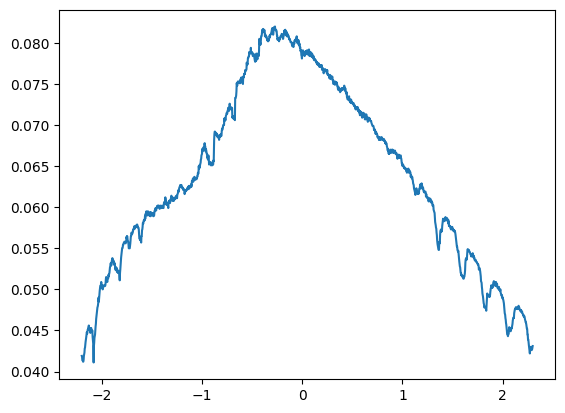

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from uncertainties import ufloat

data = pd.read_csv('Multi_25.txt', skiprows = 29,sep='\t')
 
data.columns = ['Timestamp', 'Channel A', 'Channel B', 'Unnamed']
data_1 = data.drop('Channel B', axis=1)
data_2 = data_1.drop('Unnamed', axis=1)
data_2['Channel A'] = pd.to_numeric(data_2["Channel A"], errors='coerce')
data_3 = data_2.dropna()
#print(data_3)
data_4 = data_3.to_numpy()

lin_v = 1.1/25

data_4[:,0] = data_4[:,0]*lin_v  #dist

trial1_arr = data_4[data_4[:, 0]<6.2]
trial_arr = trial1_arr[trial1_arr[:,0]>1.7]

data_zf = trial_arr[:,0]-3.9
data_T = trial_arr[:,1]

rpm = 10/(2/(60*lin_v))
print("rotation per minute is:", rpm)

plt.plot(data_zf, data_T)
plt.show()


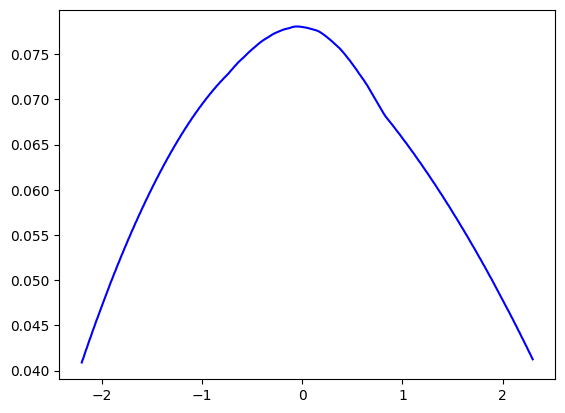

In [2]:
from scipy.signal import savgol_filter

w = savgol_filter(data_T, 1000, 2)
plt.plot(data_zf, w, 'b')  # smooth by filter

The non-linear absorption coefficient is:  (-3.4+/-0.7)e-18


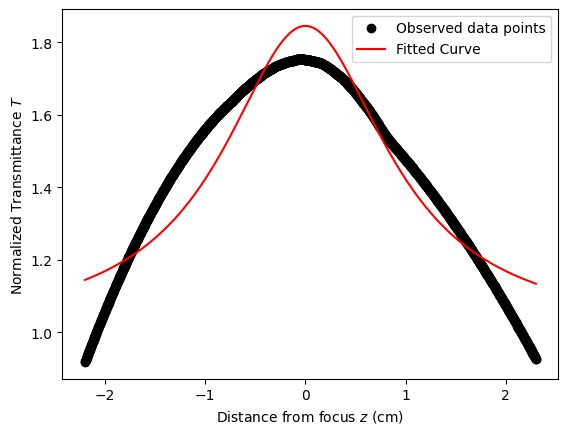

In [3]:
from scipy.optimize import curve_fit

def open_ap(z, del_psi0, N):
    return N*(1 - del_psi0/(z**2+1))

def closed_ap(z, del_psi0, del_phi0, N):
    return N*(1 + 4*del_phi0*z/((z**2+9)*(z**2+1)) - del_psi0/(z**2+1))

popt, pcov = curve_fit(open_ap, data_zf, w)

norm_val = popt[1]

err_psi = np.sqrt(np.diag(pcov))
psifi = ufloat(popt[0], err_psi[0])

p_av = ufloat(80e-3, 1e-3)
f_rep = ufloat(6e3, 1e3)
plwd = ufloat(500e-12,0)
w_0 = ufloat(20e-6,1e-6)
lam = ufloat(532e-9,0)
k = 2*np.pi/lam
I_0 = p_av/f_rep/plwd/np.pi/(w_0)**2
L_eff = ufloat(1e-3, 0.1e-3)
beta = psifi/k/I_0/L_eff

print('The non-linear absorption coefficient is: ', beta)
plt.plot(data_zf, w/norm_val, 'ko', label="Observed data points")


plt.plot(data_zf, open_ap(data_zf, *popt)/norm_val, 'r-', label="Fitted Curve")

plt.xlabel('Distance from focus $z$ (cm)')
plt.ylabel('Normalized Transmittance $T$')
plt.legend()
plt.savefig("satys-o.png", dpi = 1200, bbox_inches='tight')